# Journal 2022-08-25
Look at interactive exploration of time series data in Jupyter notebook.  Start with [IPyWidgets](https://github.com/jupyter-widgets/ipywidgets) to do date selection of a financial data price time series using a [SelectionRangeSlider](https://stackoverflow.com/questions/46756911/ipywidgets-floatrangeslider-daterangeslider) 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import yfinance as yf
import ipywidgets as widgets

Try creating a data range slider to choose date range at daily resolution.  Follow the approach from the StackExchange posts above.

In [3]:
def make_slider(start='2018', end='2023'):
    dates = pd.date_range(start, end, freq='D')
    # Slider definition
    # options = dates.to_list()  # First attempt: raw datetime object.  Works but can't see end date
    options = [(d.strftime('%Y%m%d'), d) for d in dates]  # Second attempt: (label, item) list with date format
    opt_index = (0, len(options)-1)
    slider = widgets.SelectionRangeSlider(
        index=opt_index, 
        options=options,
        layout={'width': '500px'}
    )
    return slider

make_slider()

SelectionRangeSlider(index=(0, 1826), layout=Layout(width='500px'), options=(('20180101', Timestamp('2018-01-0…

In [4]:
from ftse_constituents import get_sector_history

In [5]:
df_p = get_sector_history()

[*********************100%***********************]  10 of 10 completed


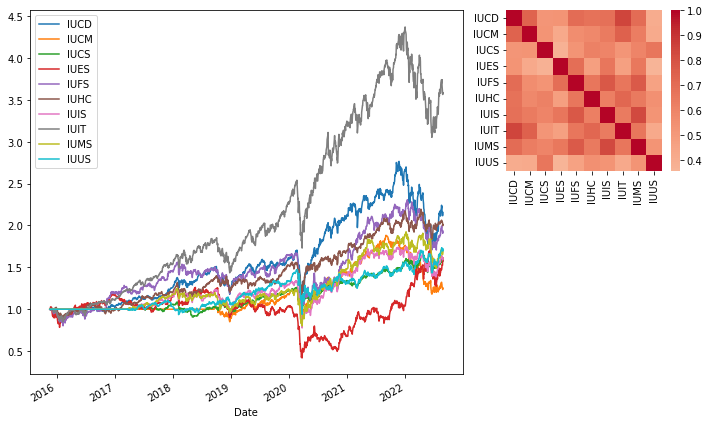

In [6]:
def select_date_range(df, date_range):
    return df['Adj Close'].loc[
        date_range[0]:date_range[-1], :
    ]

def plot_prices(date_range=None):
    fig = plt.figure(figsize=(10,6))
    gs = mpl.gridspec.GridSpec(nrows=2, ncols=3, figure=fig)
    ax = fig.add_subplot(gs[0:2,0:2])
    date_range = date_range if (date_range is not None) else df_p.index
    df_r = select_date_range(df_p, date_range).pct_change().fillna(0)
    df_r.rename(
        columns={c: c.replace('.L', '') for c in df_r.columns},
        inplace=True
    )
    df_n = (1 + df_r).cumprod()
    df_n.plot(ax=ax)
    # Add correlation plot
    ax_c = fig.add_subplot(gs[2])
    sns.heatmap(df_r.corr(), ax=ax_c, cmap='coolwarm', center=0.)
    plt.tight_layout()
plot_prices()

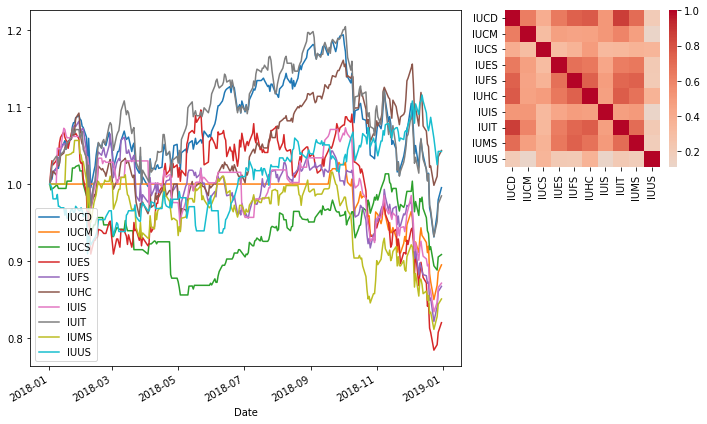

In [7]:
plot_prices(pd.date_range('2018', '2019', freq='D'))

In [9]:
_ = widgets.interact(plot_prices, date_range=make_slider('2018', '2023'))

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 1826), layout=Layout(width='500…

That seems to be working nicely, wrap it up in a class in ftse_constutuents module (which I should rename)

In [26]:
from ftse_constituents import TickerHistoryViewer

In [27]:
viewer = TickerHistoryViewer(df_p)
plot_fun = viewer.interactive('2019', '2020')

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 365), layout=Layout(width='500p…

In [24]:
plot_fun

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

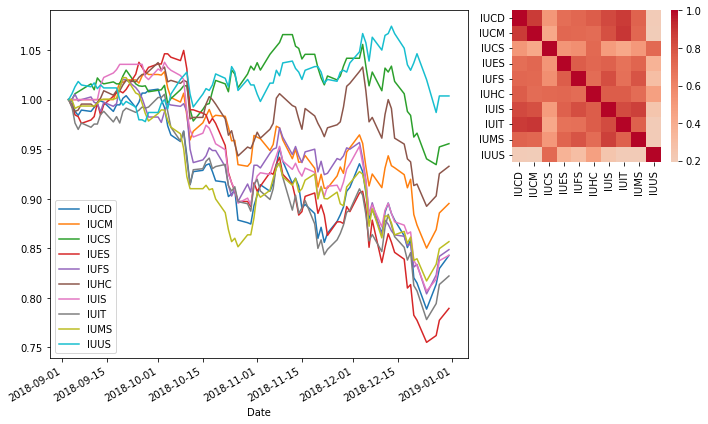

In [28]:
plot_fun(date_range=pd.date_range('2018-09-01', '2019'))